In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import io
import zipfile
import requests

# Load Data

In [42]:
url = 'https://stepik.org/media/attachments/course/4852/event_data_train.zip'

response = requests.get(url)

zipped = zipfile.ZipFile(io.BytesIO(response.content))
zfile = zipped.open(zipped.infolist()[0])
events_data=pd.read_csv(zfile)

In [43]:
url = 'https://stepik.org/media/attachments/course/4852/submissions_data_train.zip'

response = requests.get(url)

zipped = zipfile.ZipFile(io.BytesIO(response.content))
zfile = zipped.open(zipped.infolist()[0])
submissions_data=pd.read_csv(zfile)

# Data Analysing

In [44]:
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [45]:
events_data.isnull().sum()

step_id      0
timestamp    0
action       0
user_id      0
dtype: int64

In [46]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [47]:
submissions_data.isnull().sum()

step_id              0
timestamp            0
submission_status    0
user_id              0
dtype: int64

In [48]:
events_data['datetime'] = pd.to_datetime(events_data.timestamp, unit = 's')
submissions_data['datetime'] = pd.to_datetime(submissions_data.timestamp, unit = 's')

events_data['date'] = events_data.datetime.dt.date
submissions_data['date'] = submissions_data.datetime.dt.date


In [49]:
def hour2partDay(x):
    if 6 < x <= 11:
        return 'morning'
    if 11< x <= 17:
        return 'day'
    if 17 < x <= 22:
        return 'evening'
    else: 
        return 'night'

events_data['hour'] = events_data.datetime.dt.hour

a = events_data[['user_id', 'date', 'hour']].drop_duplicates()
a['time_of_day'] = a['hour'].apply(lambda x: hour2partDay(x))
a = pd.get_dummies(a, columns=['time_of_day'],dtype=int)

most_freq_part_day = a.groupby(['user_id','date'], as_index=False)\
                                .agg({'time_of_day_day': 'sum', 'time_of_day_evening': 'sum', 'time_of_day_morning': 'sum', 'time_of_day_night': 'sum'})\
                                .rename(columns={'time_of_day_day':'part_day','time_of_day_evening':'part_evening','time_of_day_morning':'part_morning','time_of_day_night':'part_night'})
a = most_freq_part_day
a['most_freq'] = a[['part_day', 'part_evening', 'part_morning','part_night']].idxmax(axis=1)
a = a.drop(['part_day','part_evening','part_morning','part_night'], axis = 1)
most_freq_part_day = pd.get_dummies(a, columns=['most_freq'], dtype=int).groupby(['user_id'], as_index=False).agg({'most_freq_part_day': 'sum', 'most_freq_part_evening': 'sum', 'most_freq_part_morning': 'sum', 'most_freq_part_night': 'sum'})
most_freq_part_day.head()

,user_id,most_freq_part_day,most_freq_part_evening,most_freq_part_morning,most_freq_part_night
0,1,1,0,0,0
1,2,2,0,0,0
2,3,3,0,3,1
3,5,0,0,2,0
4,7,1,0,0,0


Text(0, 0.5, 'Counts of users')

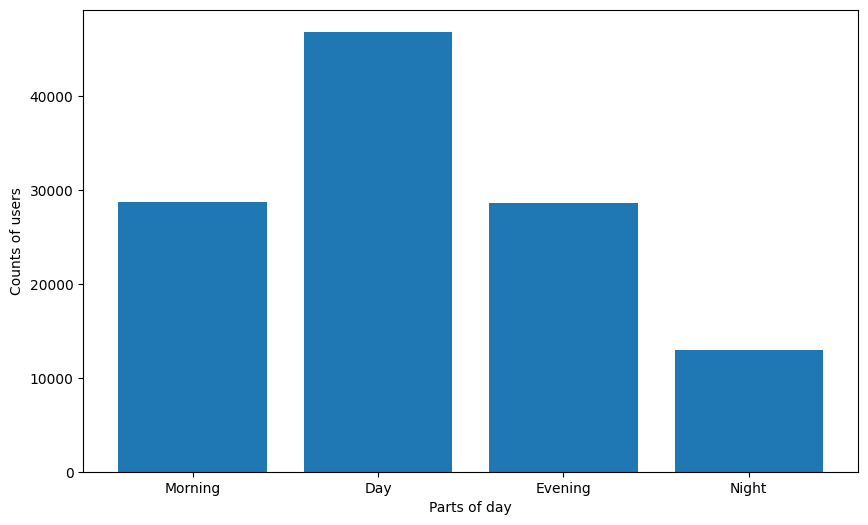

In [50]:
parts_day = ['Morning', 'Day', 'Evening', 'Night']
counts = [most_freq_part_day['most_freq_part_morning'].sum(), most_freq_part_day['most_freq_part_day'].sum(), most_freq_part_day['most_freq_part_evening'].sum(),  most_freq_part_day['most_freq_part_night'].sum()]

plt.figure(figsize=(10,6))

plt.bar(parts_day, counts)
plt.xlabel('Parts of day')
plt.ylabel('Counts of users')

<Axes: xlabel='date'>

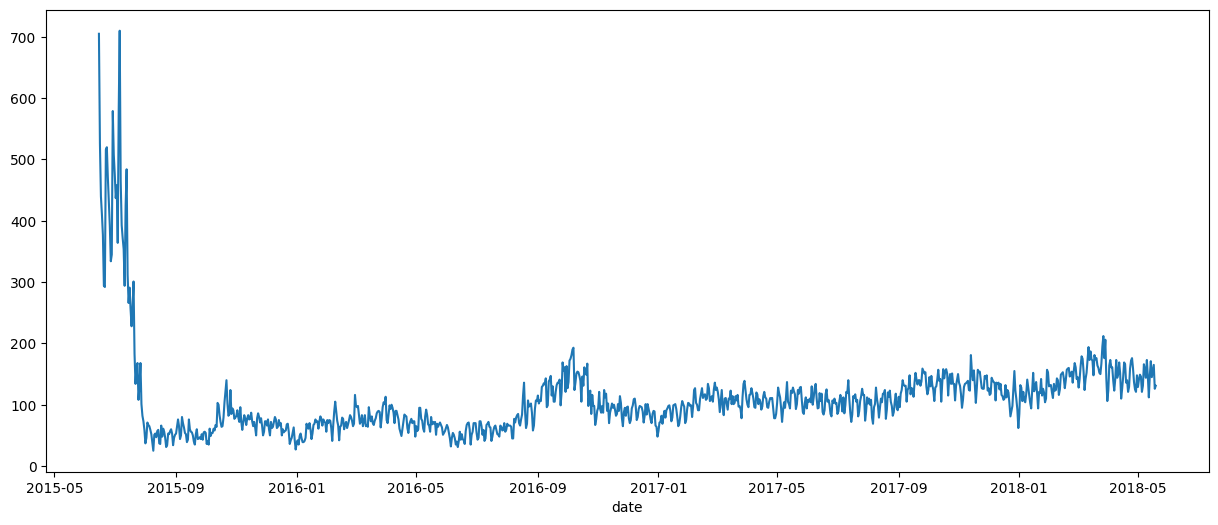

In [51]:
plt.figure(figsize=(15,6))
events_data.groupby('date').user_id.nunique().plot()

# Data Preprocesing

In [52]:
sub_status_data = events_data.pivot_table(index = 'user_id', 
                        columns= 'action', 
                        aggfunc='count', 
                        values = 'step_id', 
                        fill_value=0).reset_index()

In [53]:
user_scores = submissions_data.pivot_table(index = 'user_id'\
                                           ,columns='submission_status'\
                                           ,values = 'step_id'\
                                           ,aggfunc='count'\
                                           ,fill_value=0).reset_index()

In [54]:
#Difference between 2 lasts entring of user

gap_data = events_data[['user_id', 'date','timestamp']].drop_duplicates(subset=['date', 'user_id'])\
            .groupby('user_id')['timestamp'].apply(list)\
            .apply(np.diff).values

TIMESTAMP_DAY = 60*60*24

gap_data = (pd.Series(np.concatenate(gap_data))) / TIMESTAMP_DAY

<Axes: >

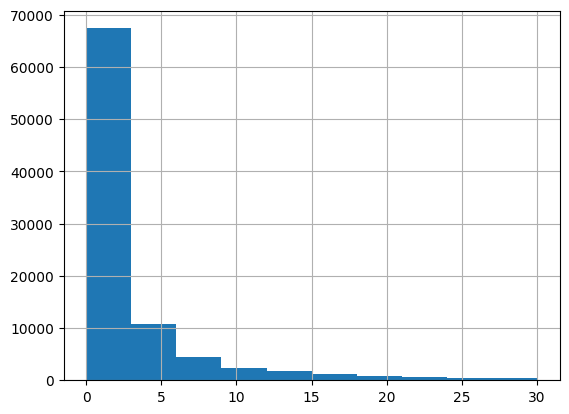

In [55]:
THRESHOLD_OF_DAYS = 30
gap_data[gap_data<THRESHOLD_OF_DAYS].hist() 

In [56]:
Persent = 0.92 
gap_data.quantile(Persent)

np.float64(27.452338425926104)

In [57]:
#search last enter of user
user_data = events_data.groupby('user_id', as_index=False).agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

In [58]:
user_data.head()

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [59]:
now = events_data['timestamp'].max()
drop_out = THRESHOLD_OF_DAYS * 24 * 60 * 60

count_user_days = events_data.groupby('user_id',as_index=False).date.nunique().rename({'date': 'count_user_days'}, axis=1)

user_data['user_is_gone'] = ((now - user_data.last_timestamp) > drop_out)*1
user_data = user_data.merge(user_scores, how='left')\
                     .merge(sub_status_data, how = 'left')\
                     .merge(count_user_days, how = 'left')\
                     .merge(most_freq_part_day, how= 'left').fillna(0)
                

<Axes: >

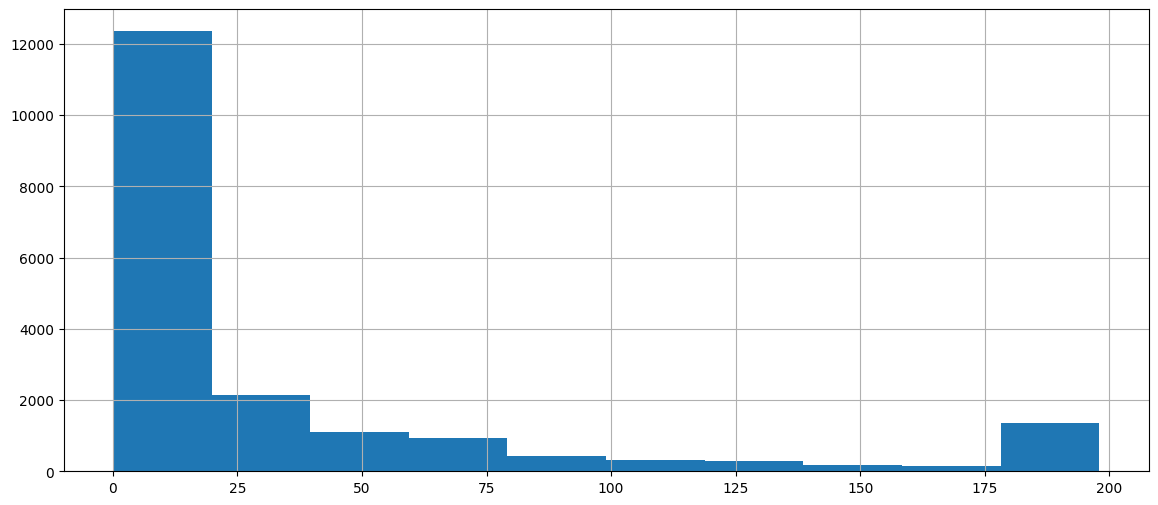

In [62]:
plt.figure(figsize=(14,6))
user_data.passed.hist()

Text(0.5, 0, 'User is gone')

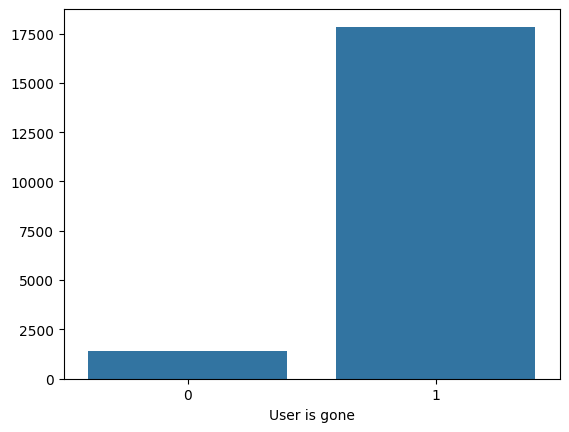

In [66]:
sns.barplot(x = user_data.user_is_gone.unique(), y = list(user_data.user_is_gone.value_counts()))
plt.xlabel('User is gone')

In [67]:
user_data.head()

,user_id,last_timestamp,user_is_gone,correct,wrong,discovered,passed,started_attempt,viewed,count_user_days,most_freq_part_day,most_freq_part_evening,most_freq_part_morning,most_freq_part_night
0,1,1472827464,1,0.0,0.0,1,0,0,1,1,1,0,0,0
1,2,1519226966,1,2.0,0.0,9,9,2,10,2,2,0,0,0
2,3,1444581588,1,29.0,23.0,91,87,30,192,7,3,0,3,1
3,5,1499859939,1,2.0,2.0,11,11,4,12,2,0,0,2,0
4,7,1521634660,1,0.0,0.0,1,1,0,1,1,1,0,0,0


# Baseline modeling with RandomForestRegressor

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score
from sklearn.tree import plot_tree

In [69]:
X = user_data.drop(['user_id','last_timestamp', 'user_is_gone'],axis = 1)
y = user_data.user_is_gone

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [70]:
parameters = [{'n_estimators': list(range(5,20)),
              'max_depth': list(range(4,7)),
              'min_samples_split': [120, 400, 600],
              }]

grid_cv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameters, n_jobs=4, cv=5)

In [71]:
grid_cv.fit(X=X_train, y=y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid=[{'max_depth': [4, 5, 6],
                          'min_samples_split': [120, 400, 600],
                          'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                           15, 16, 17, 18, 19]}])

In [72]:
model = grid_cv.best_estimator_
len(model.estimators_)

16

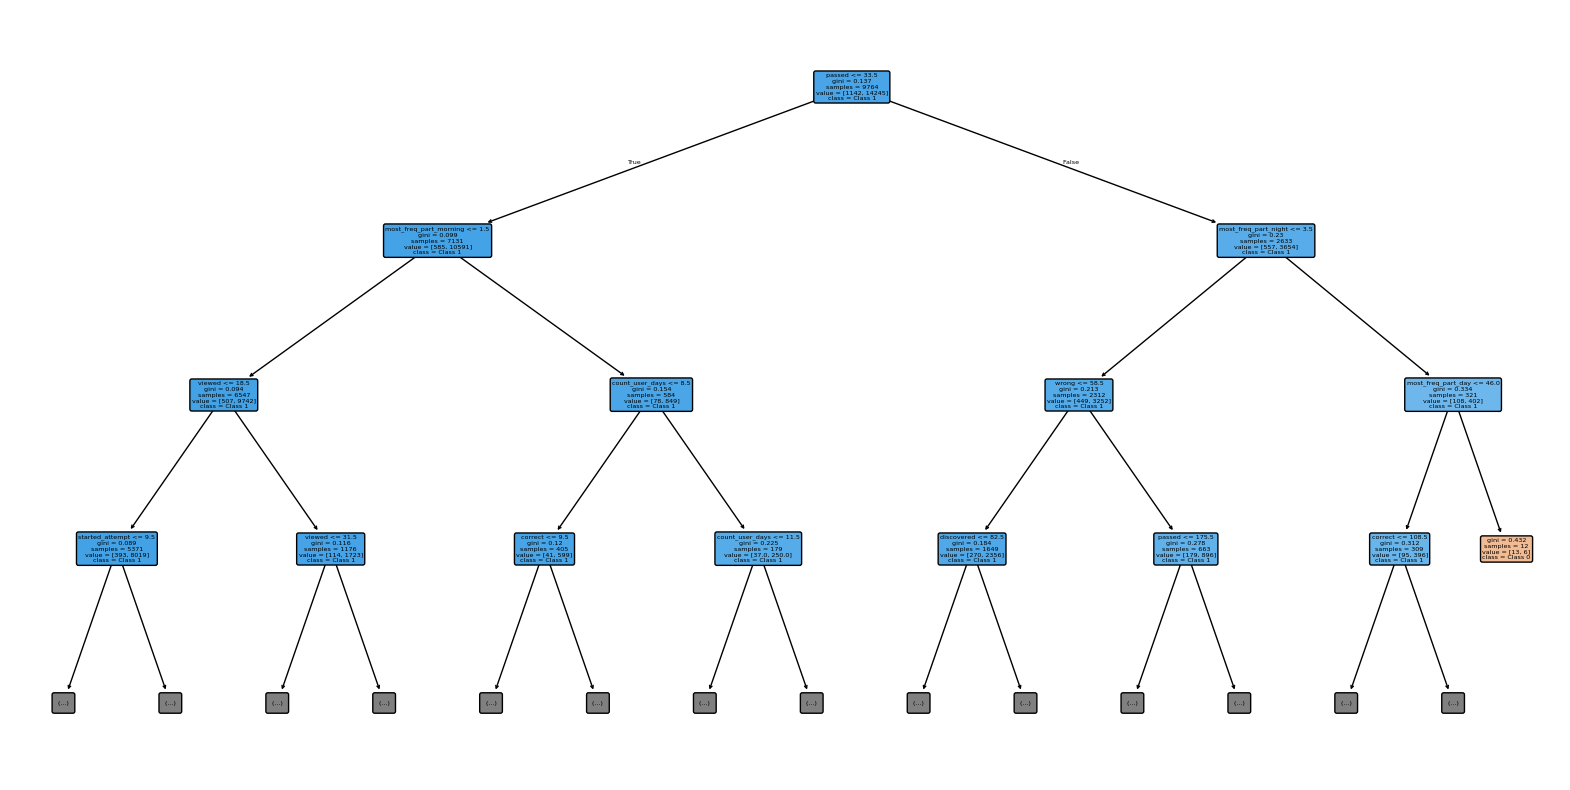

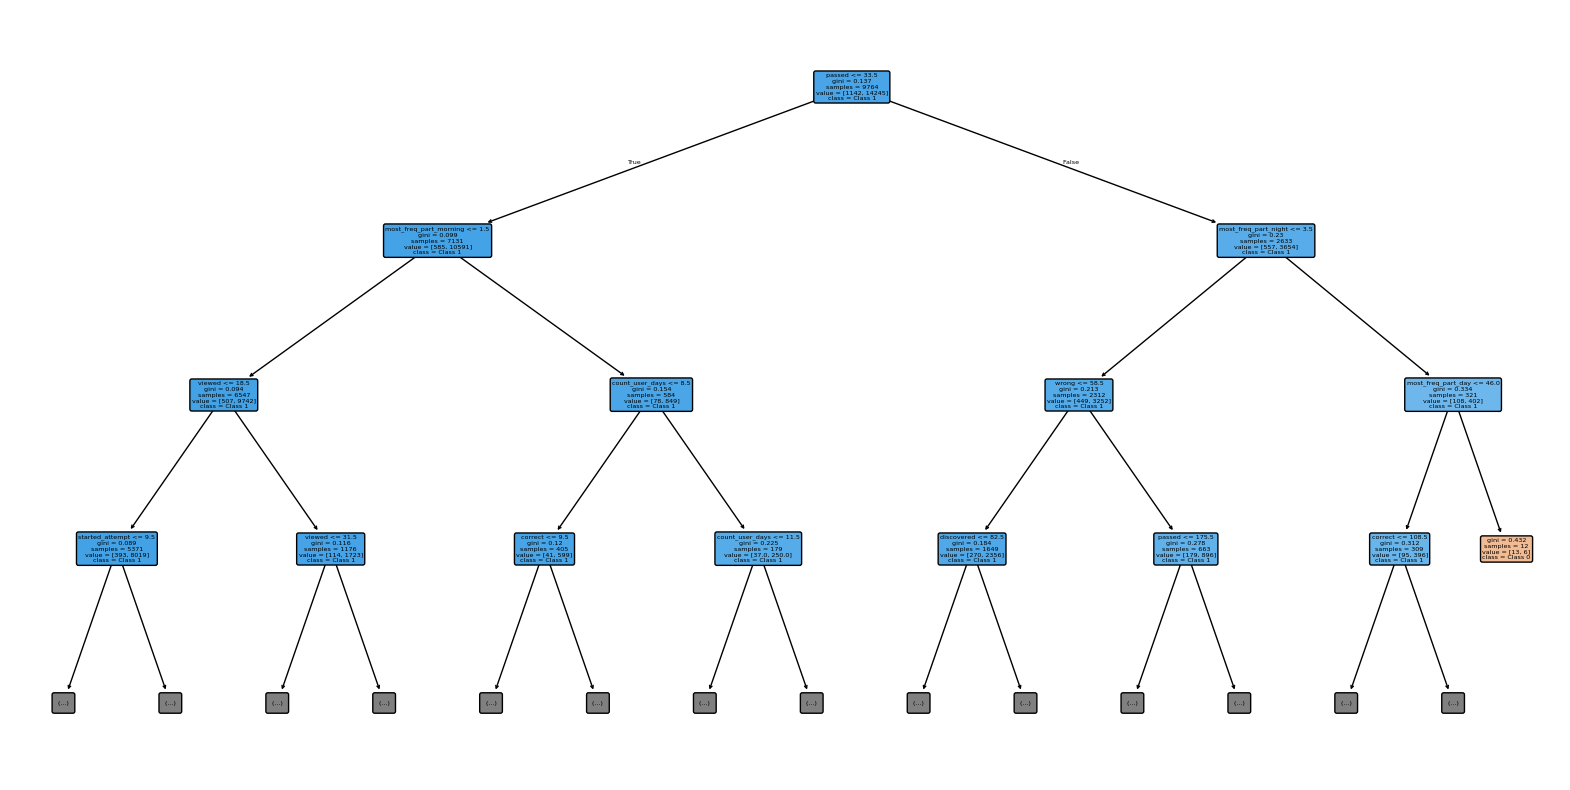

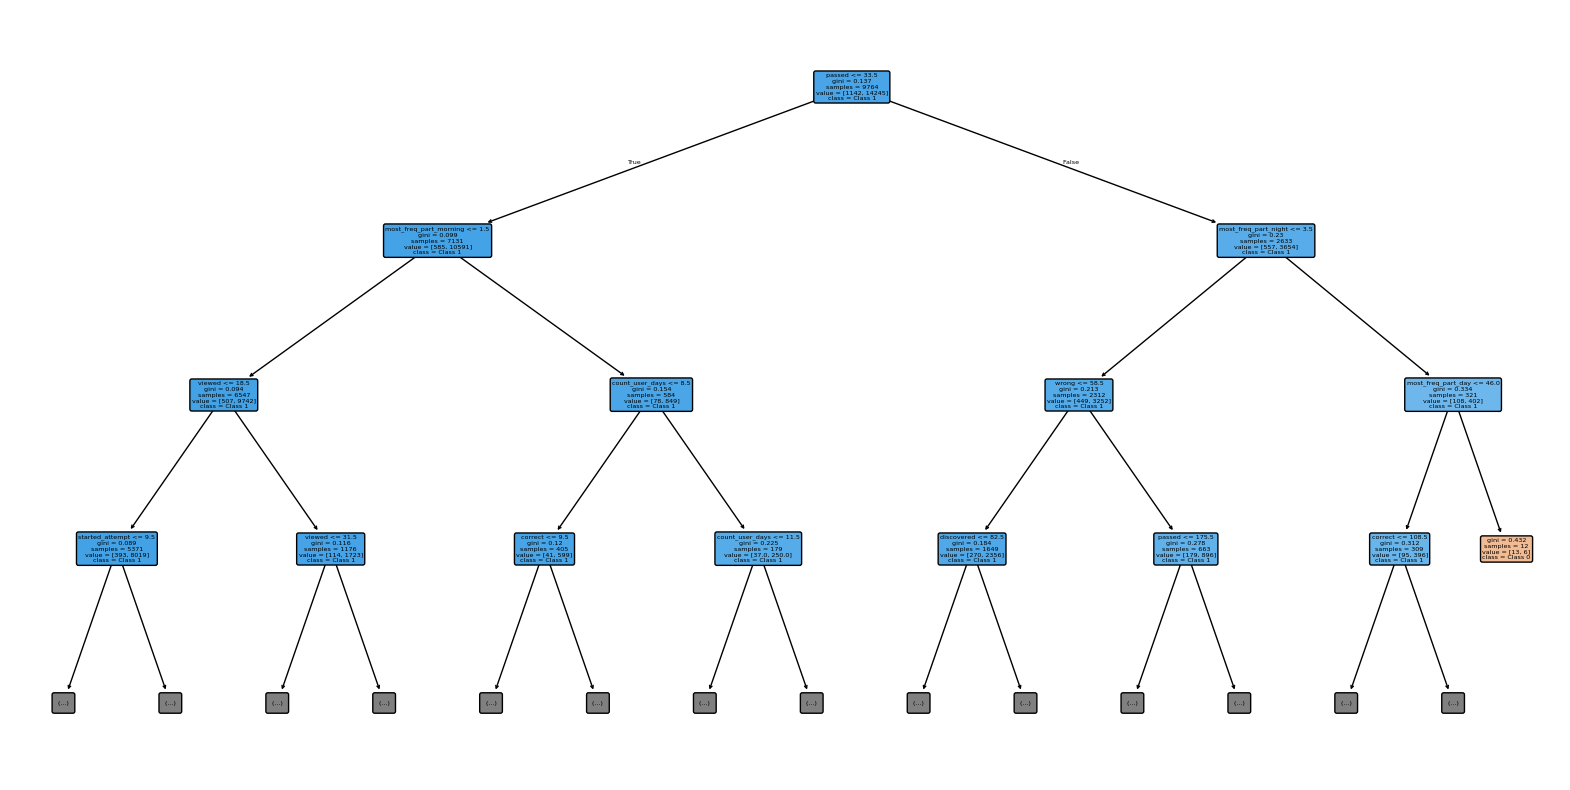

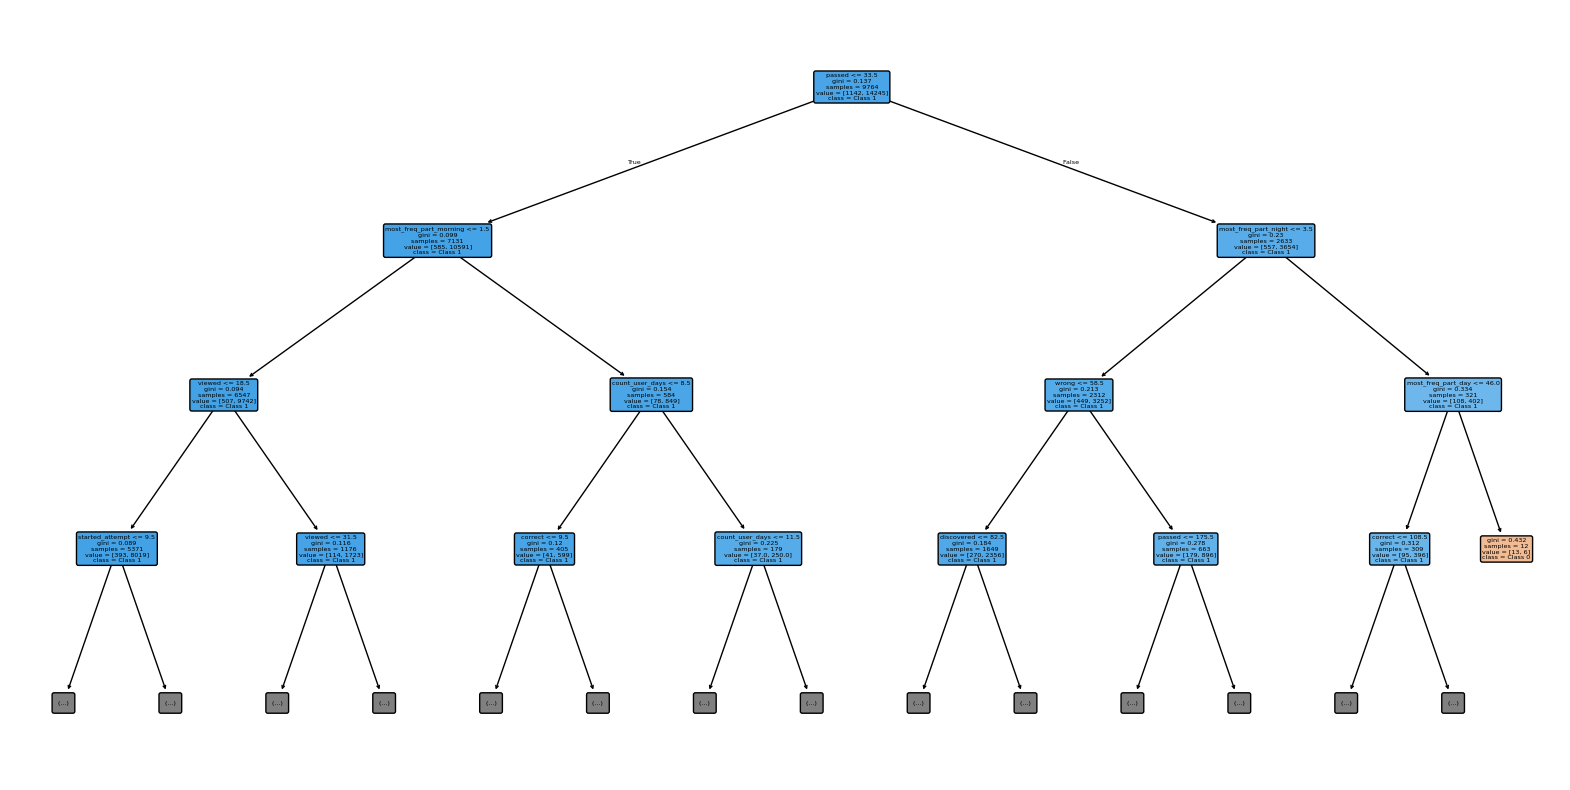

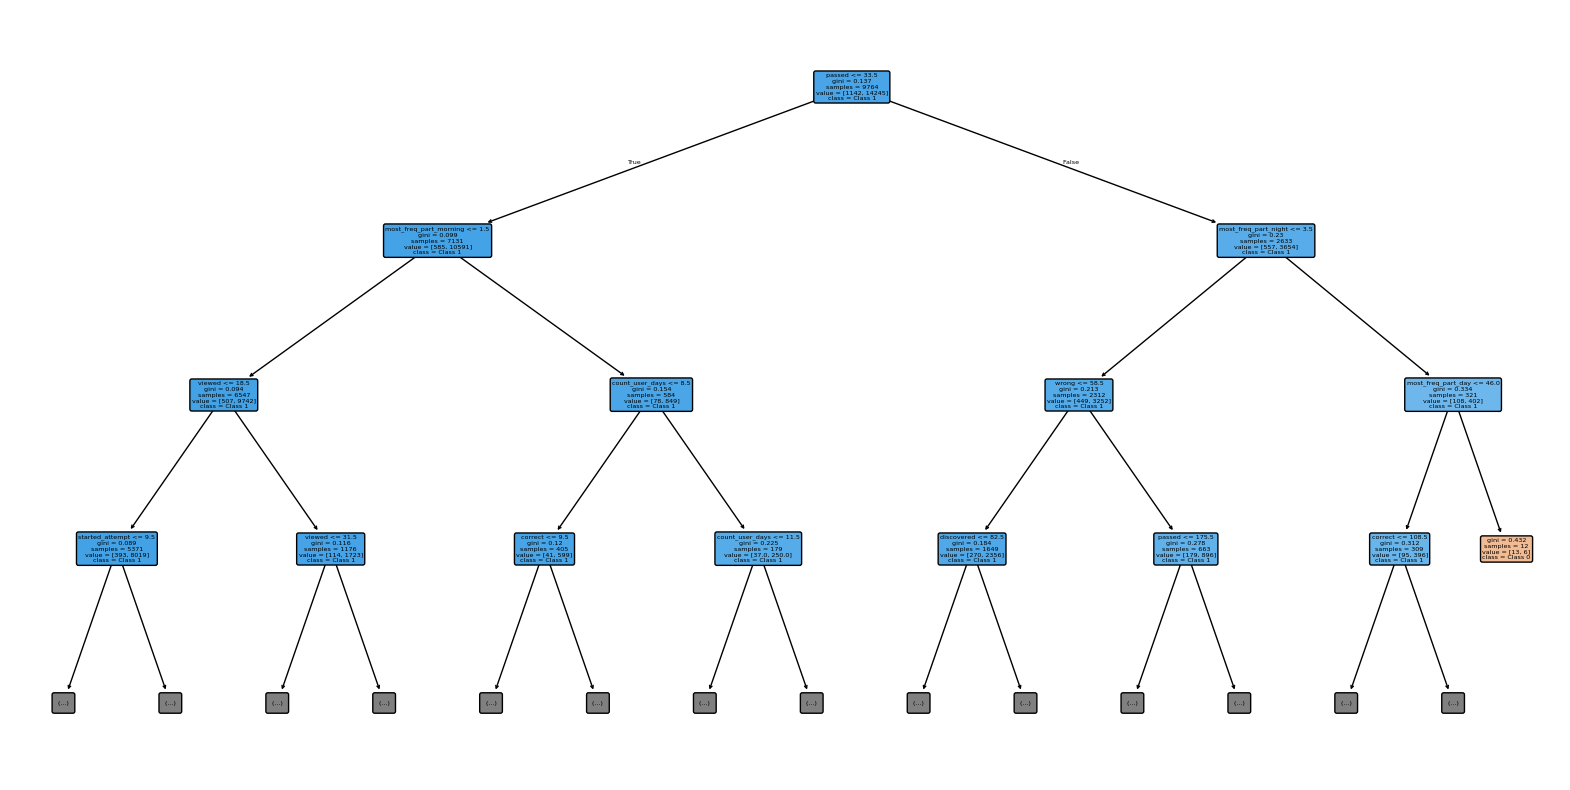

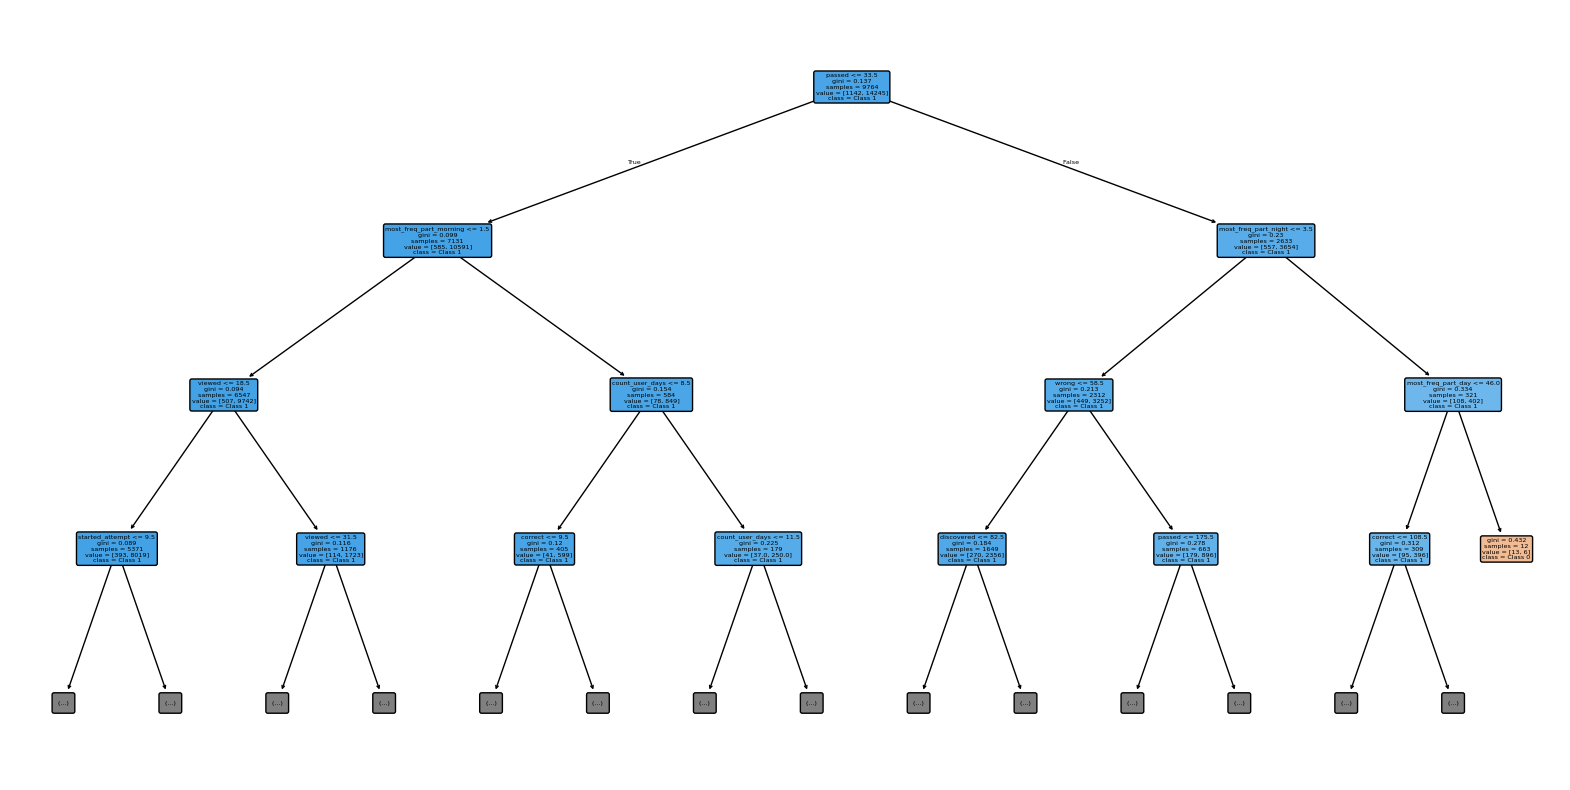

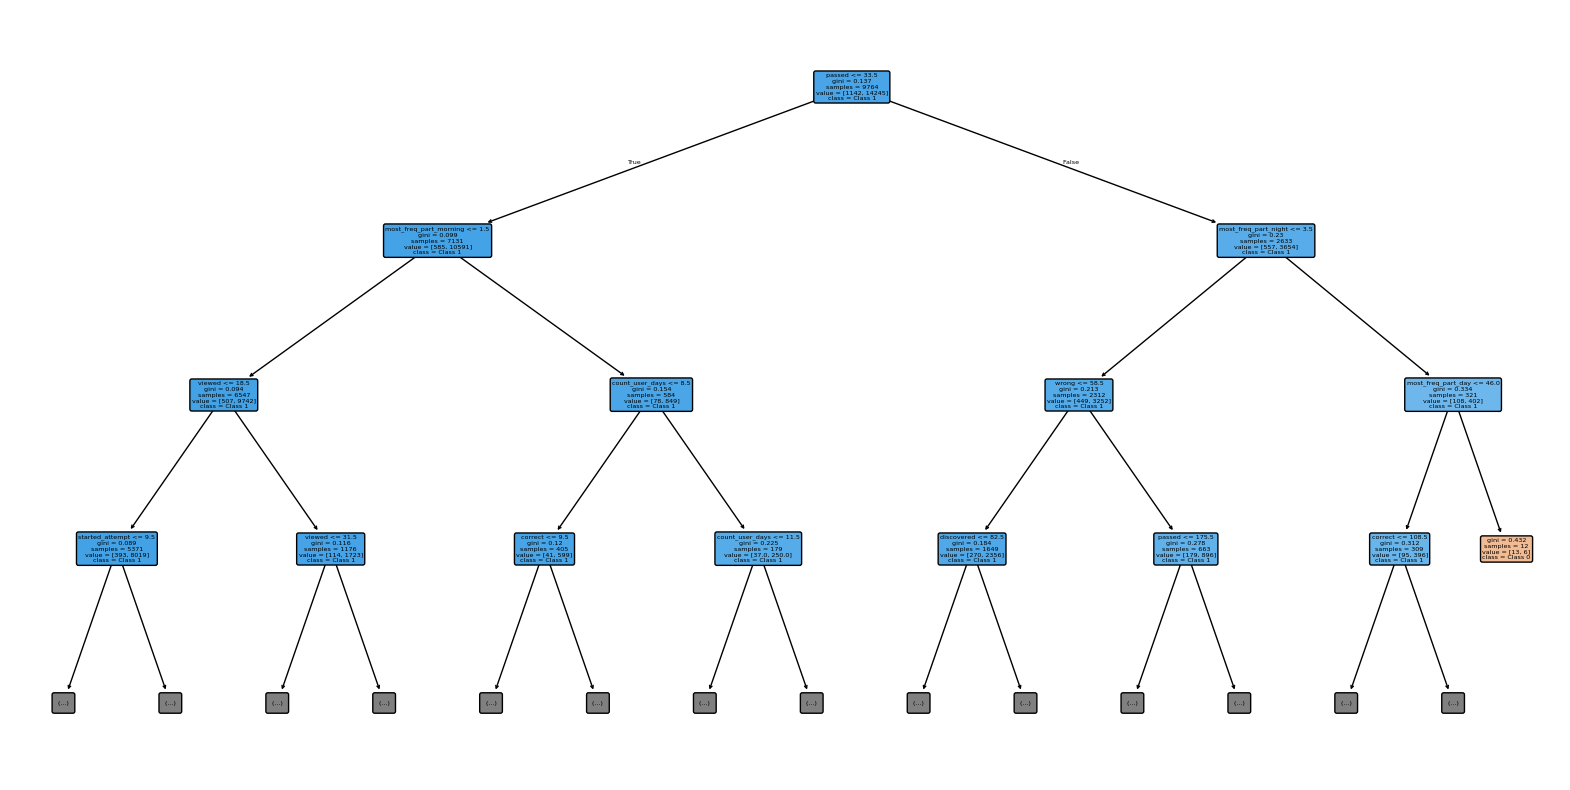

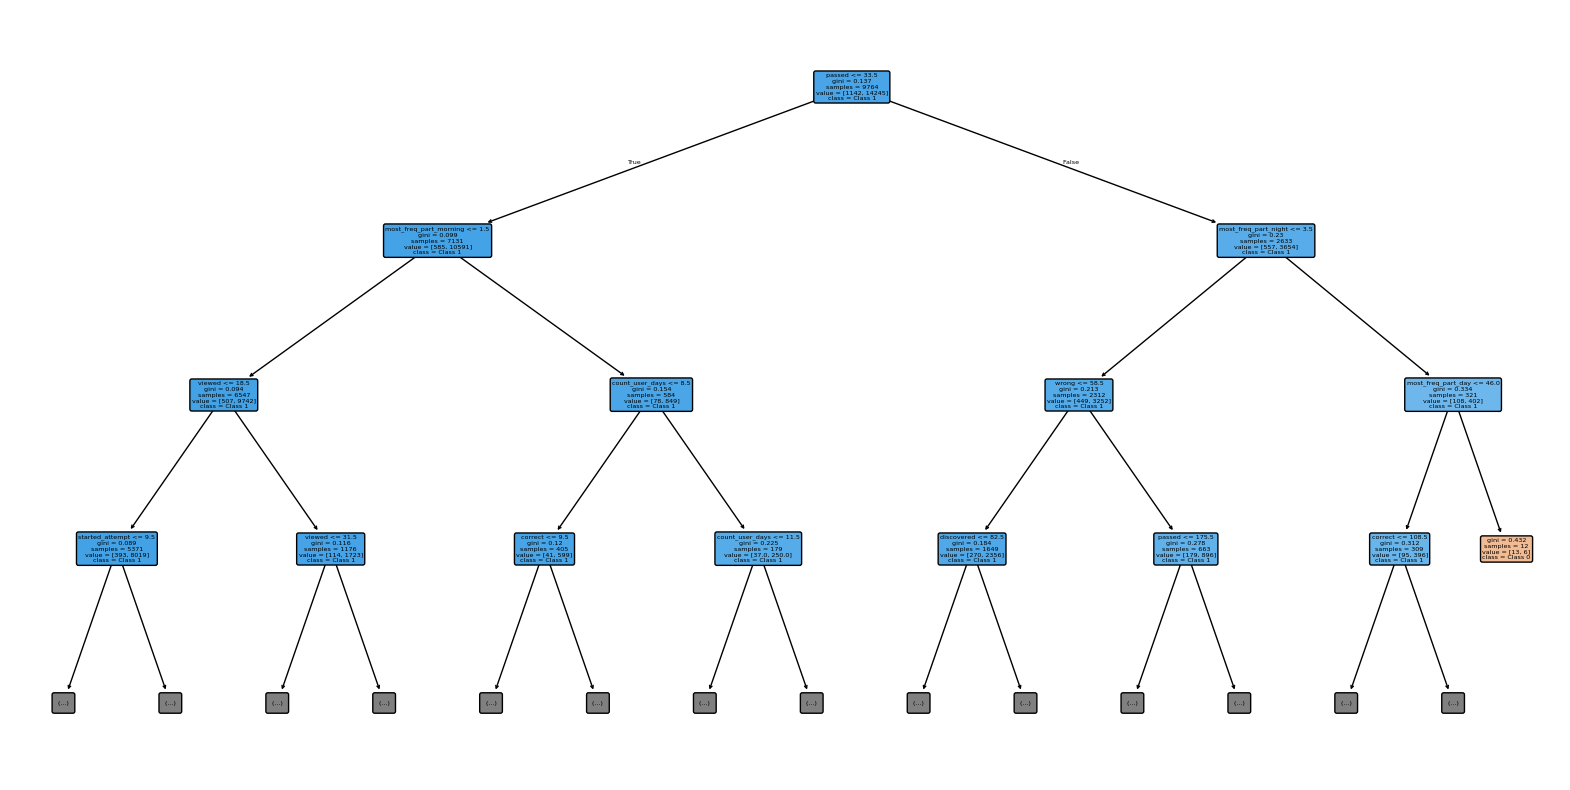

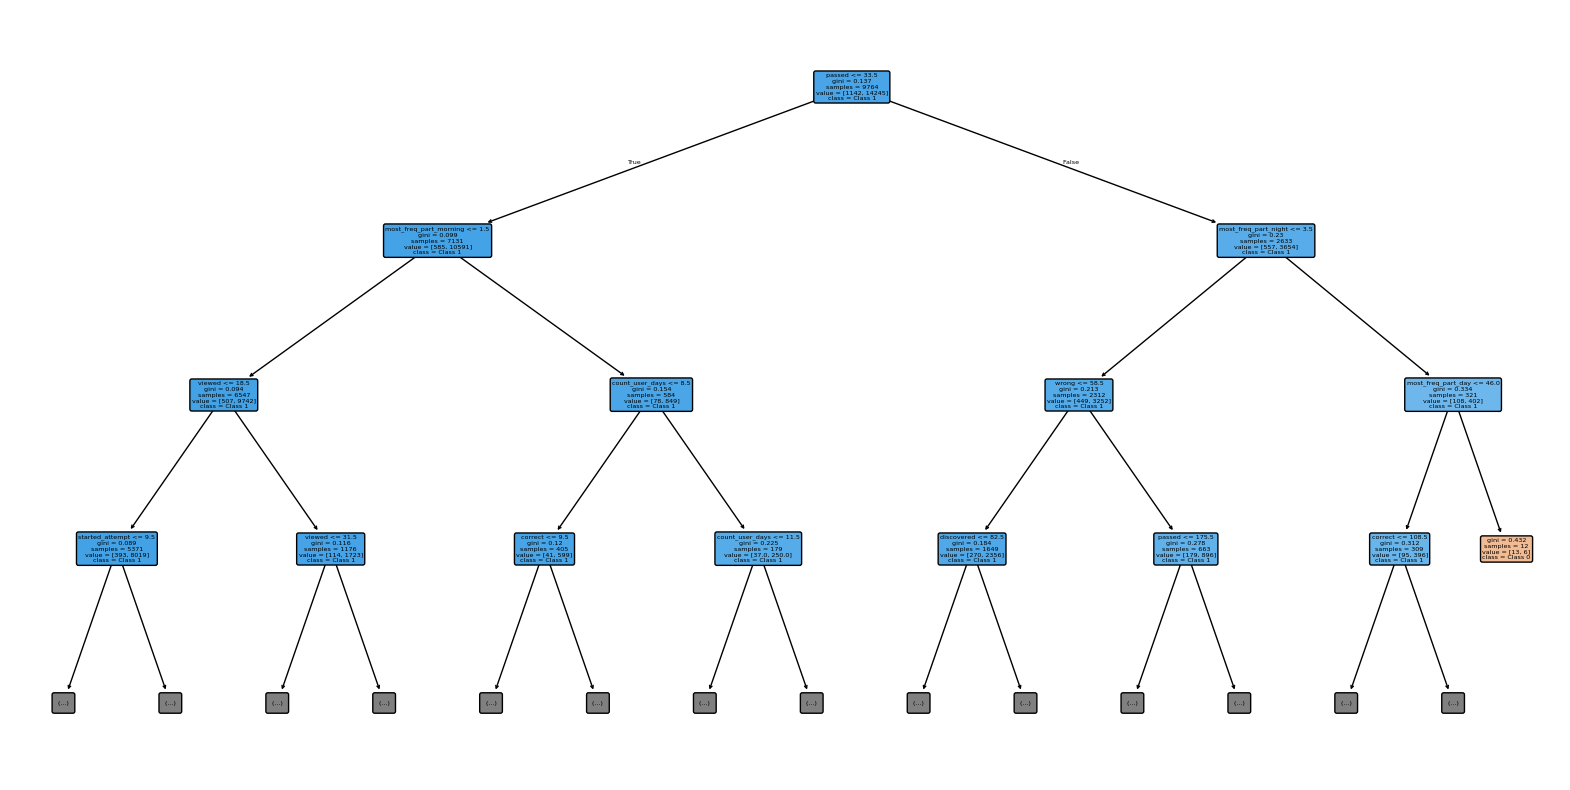

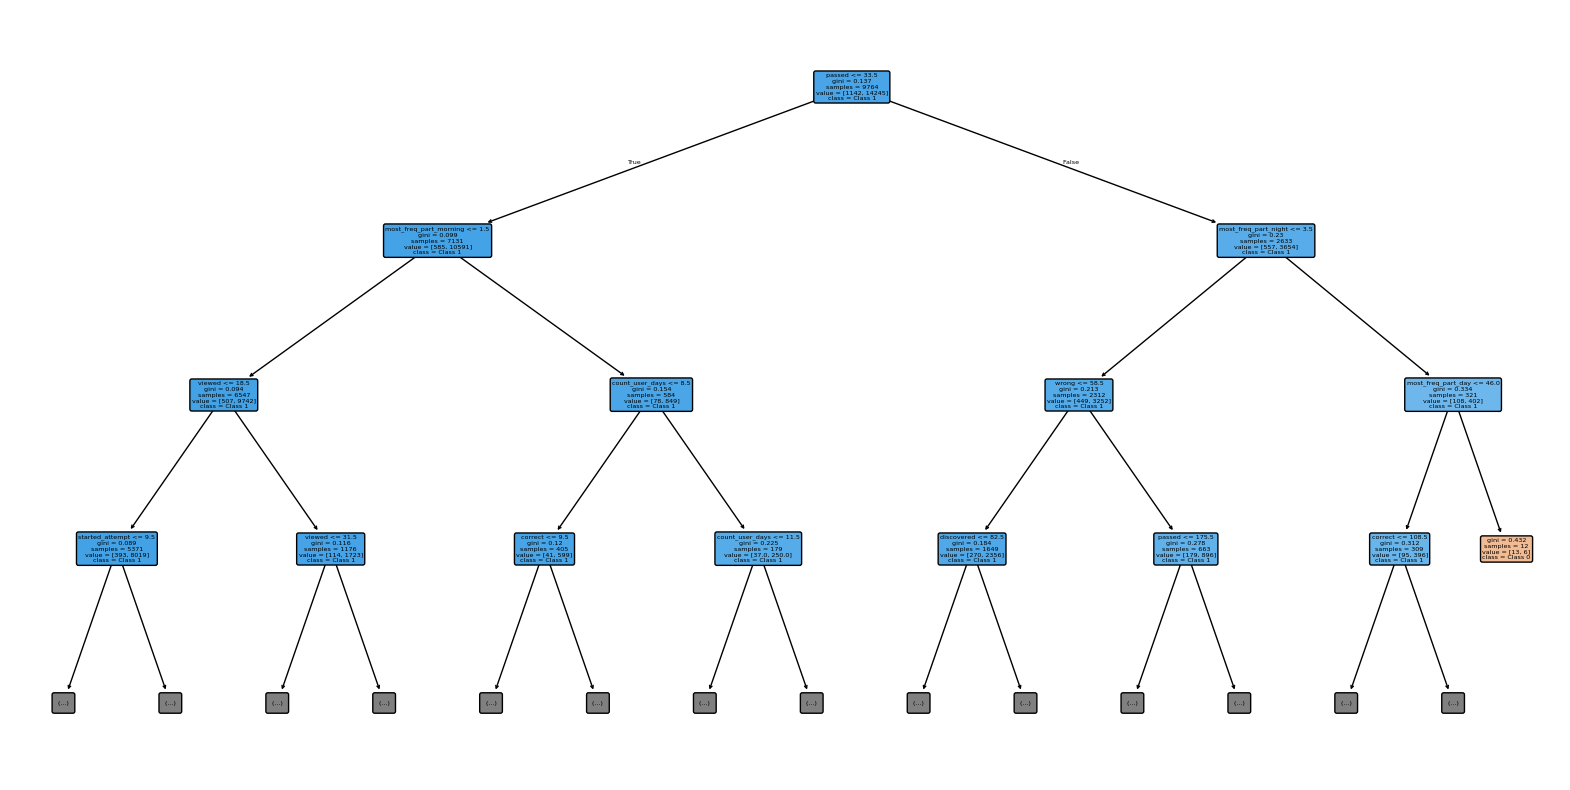

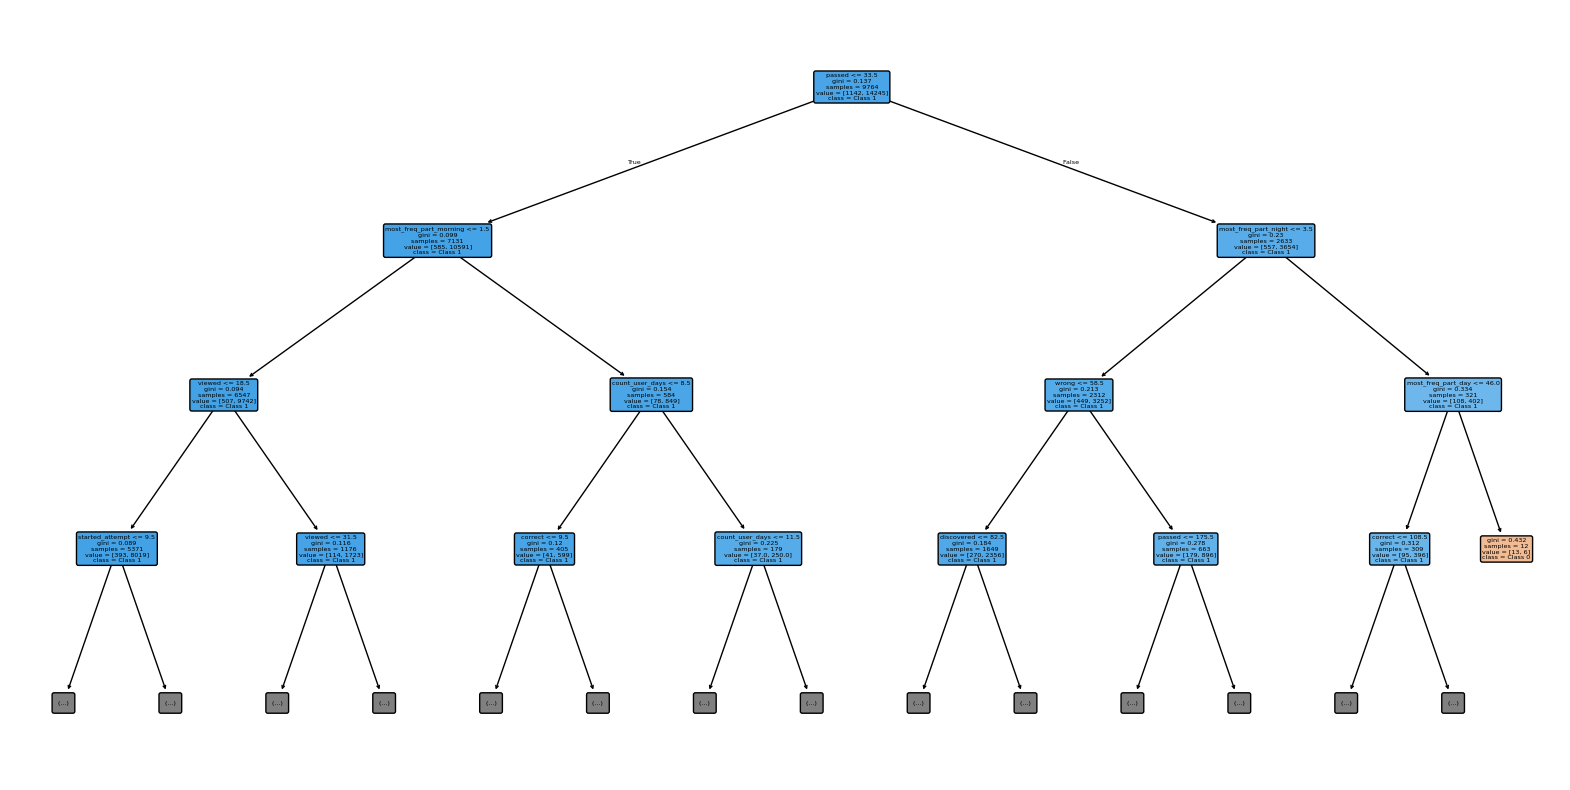

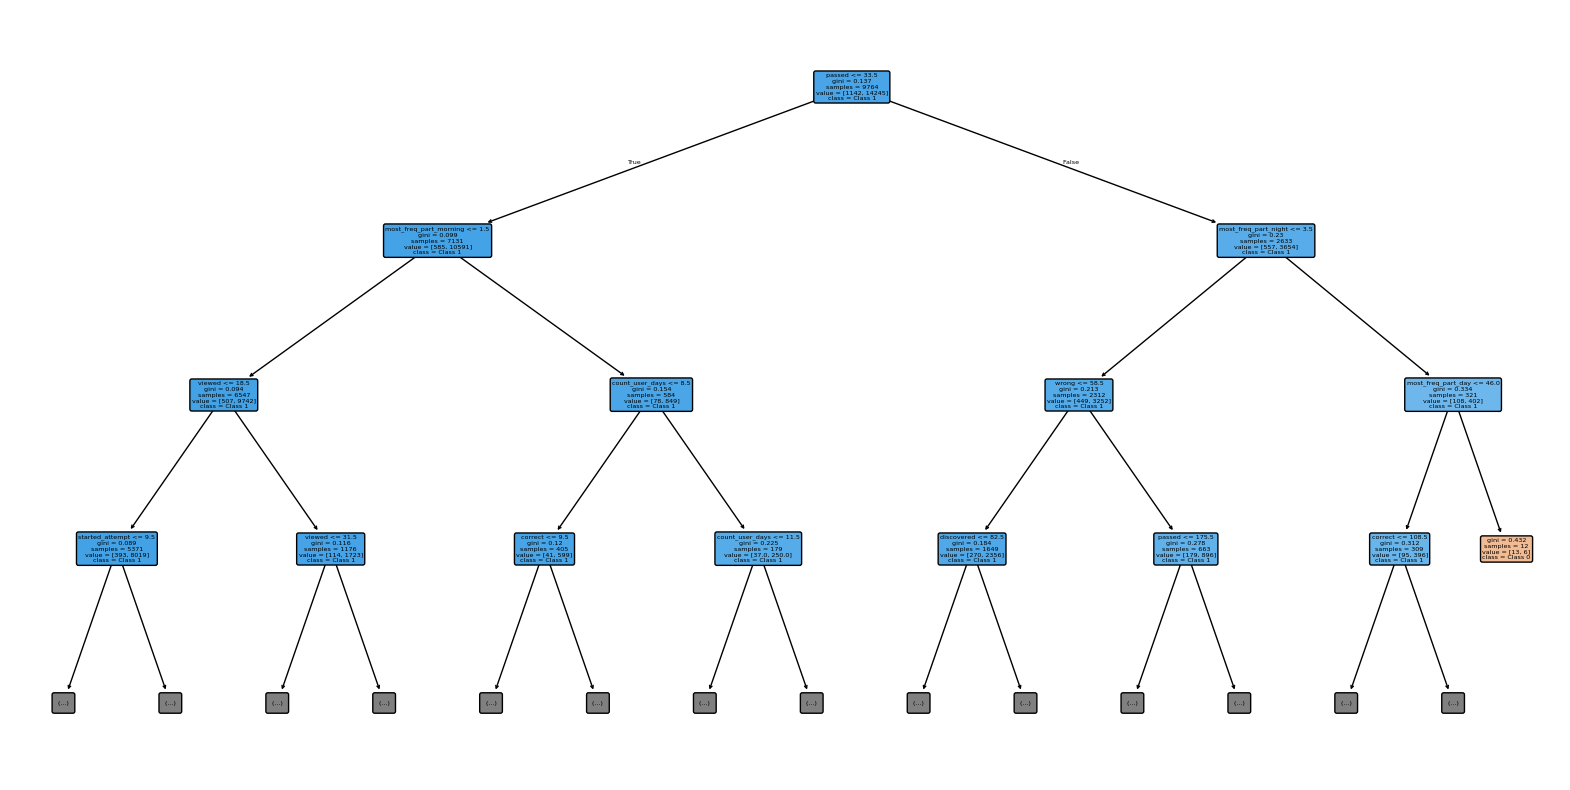

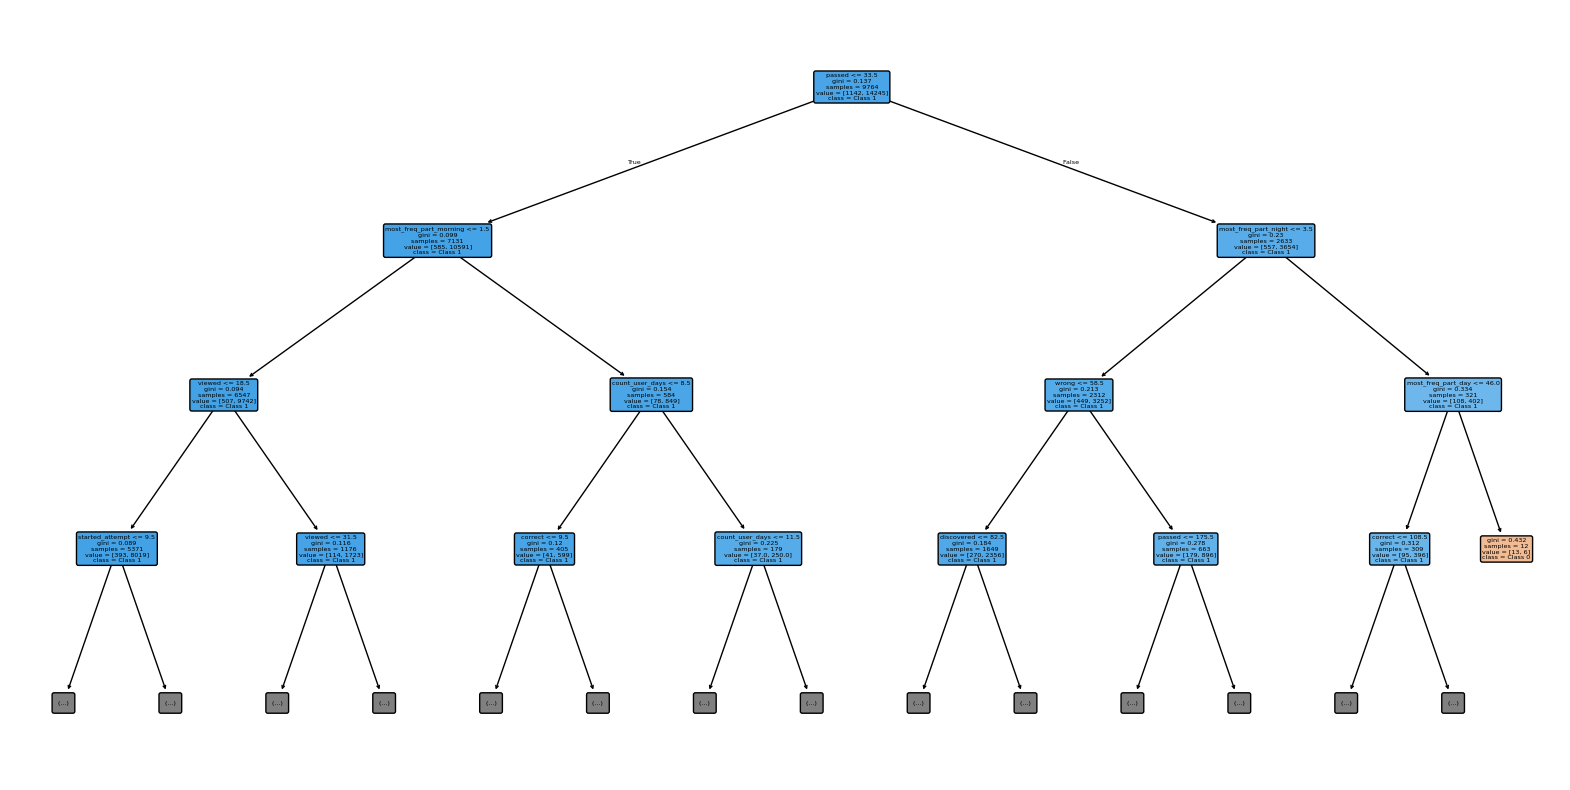

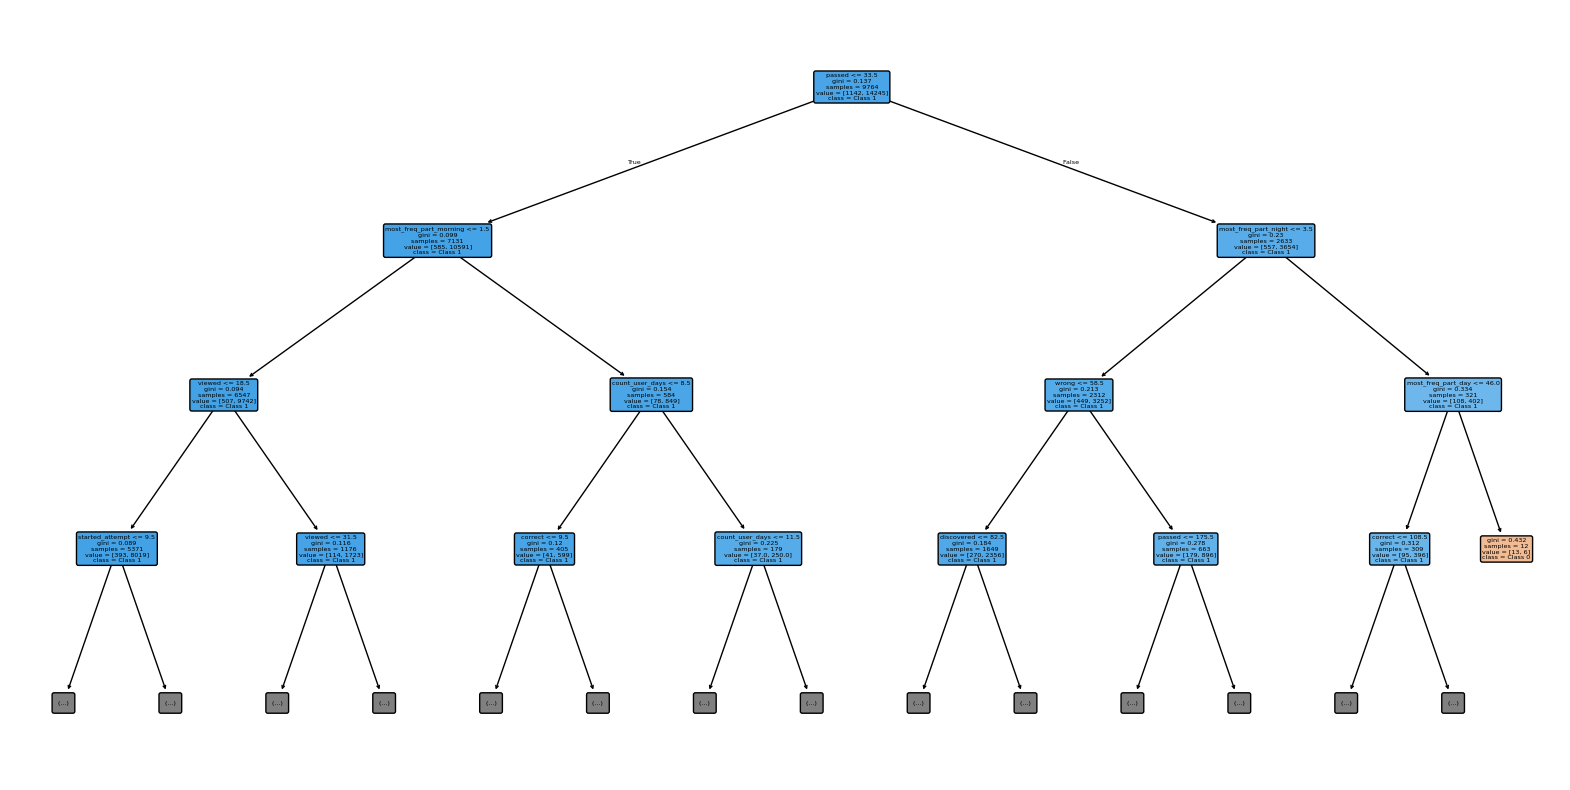

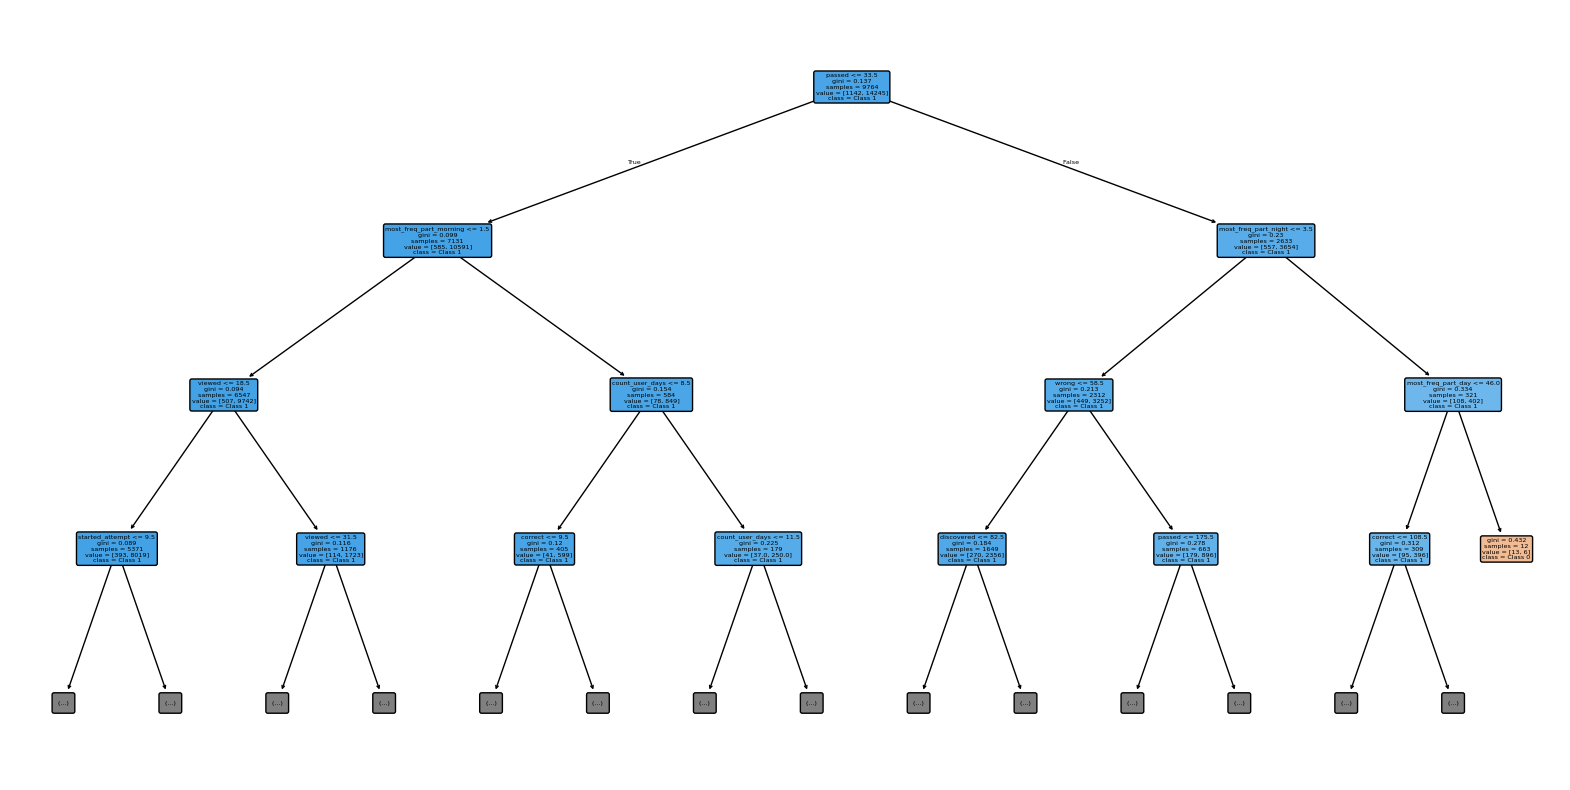

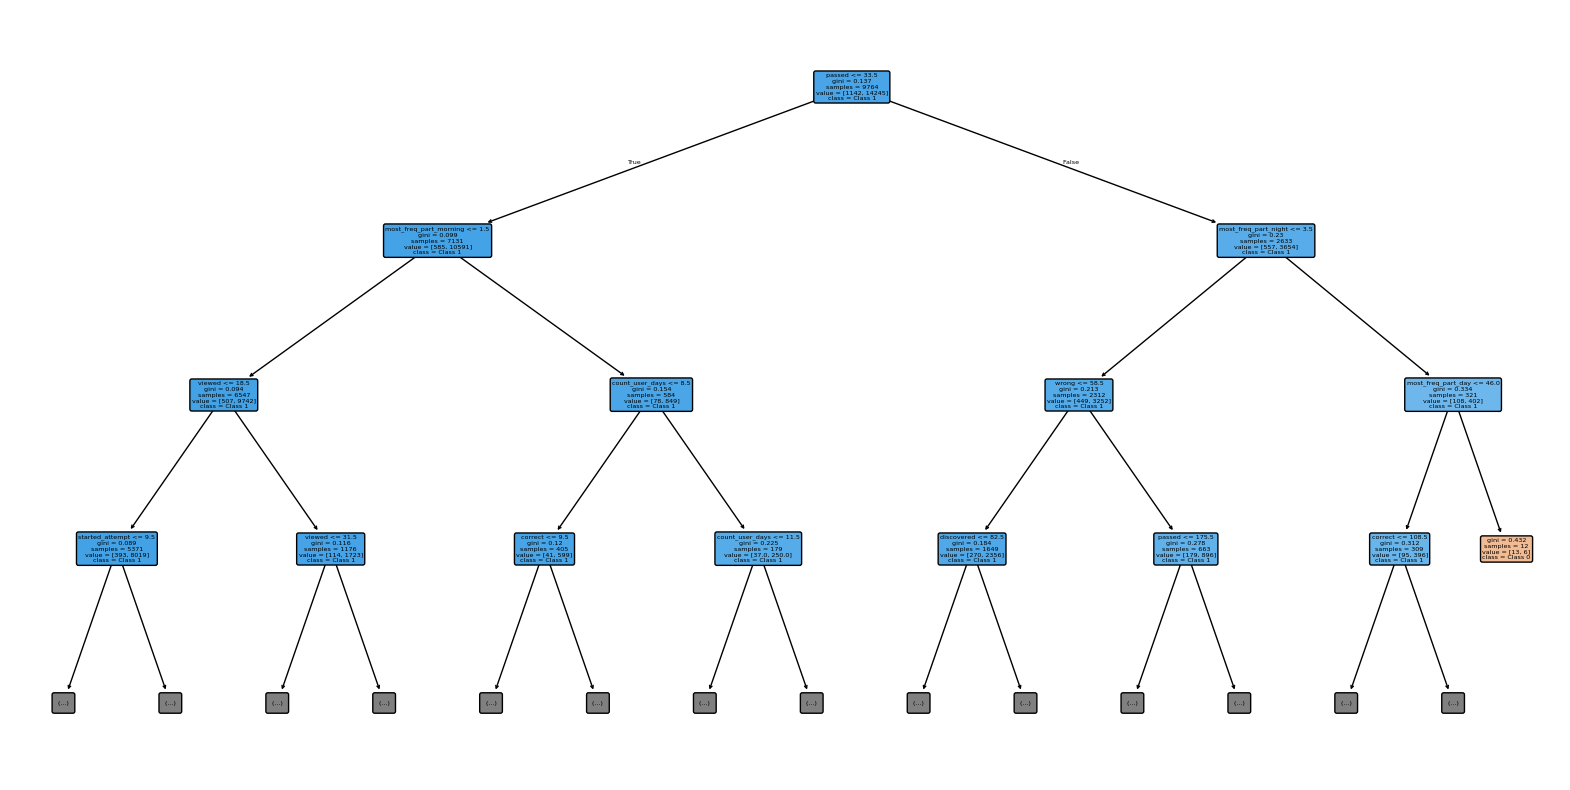

In [73]:
for index in range(len(model.estimators_)):
    plt.figure(figsize=(20, 10))
    plot_tree(model.estimators_[0], 
          feature_names=X_train.columns,  # Имена признаков
          class_names=['Class 0', 'Class 1'],  # Имена классов (для классификации)
          filled=True, 
          rounded=True,
          max_depth=3,) 
    plt.show()

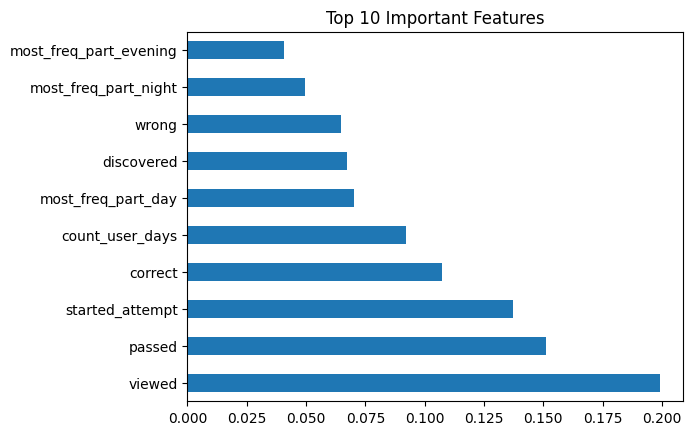

In [75]:
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Important Features')
plt.show()

In [ ]:
print(f"F1-score Train data: {f1_score(y_train, model.predict(X_train))}\nF1-score Train data: {f1_score(y_test, model.predict(X_test))}")

F1-score Train data: 0.9630353472386023
F1-score Train data: 0.9604107553033374
